### Pre-processing

In [258]:
import pandas as pd
import psycopg2
import json
import numpy as np
import random
import matplotlib.pyplot as plt

In [3]:
# Read datasets

arrests = pd.read_csv('../../data/chicago-open-data/Arrests.csv')
chi_pub_school = pd.read_csv('../../data/chicago-open-data/Chicago_Public_Schools_-_School_Profile_Information_SY1617.csv')
violence_reduction = pd.read_csv('../../data/chicago-open-data/Violence_Reduction_-_Victims_of_Homicides_and_Non-Fatal_Shootings.csv')
crimes = pd.read_csv('../../data/chicago-open-data/Crimes_-_2001_to_Present.csv')
life_exp_by_race = pd.read_csv('../../data/chicago-open-data/Public_Health_Statistics_-_Life_Expectancy_By_Race_Ethnicity_-_Historical.csv')
life_exp_by_comm_area= pd.read_csv('../../data/chicago-open-data/Public_Health_Statistics_-_Life_Expectancy_By_Community_Area_-_Historical.csv')
# population_census_by_block= pd.read_csv('../../data/chicago-open-data/Population_by_2010_Census_Block.csv')
population_counts= pd.read_csv('../../data/chicago-open-data/Chicago_Population_Counts.csv')
public_health_indicators_by_comm_area = pd.read_csv('../../data/chicago-open-data/Public_Health_Statistics_-_Selected_public_health_indicators_by_Chicago_community_area_-_Historical.csv')

In [4]:
tables = [arrests, chi_pub_school, violence_reduction, crimes, life_exp_by_race, life_exp_by_comm_area, population_counts, public_health_indicators_by_comm_area]

In [21]:
%%capture
for table in tables:
    table_name = [var for var in globals() if globals()[var] is table][0]
    print(table_name, table.size, 'x', table.columns.size)
    print('============================')

In [22]:
%%capture
for table in tables:
    table_name = [var for var in globals() if globals()[var] is table][0]
    print(table_name, table.columns)
    print('============================')

### Cleaning Dataset

In [70]:
violence_reduction.dropna(subset=['ZIP_CODE'], inplace=True)

### Connect to Database

In [ ]:
conn = psycopg2.connect(
    host="localhost",
    database="chicago_open_data",
    user="adityakanthale",
)
cur = conn.cursor()

res = cur.execute("SELECT * FROM arrests WHERE race='BLACK';")

In [114]:
## print large output to file
def write_to_file(output_data, file_name):
    with open('./out/'+file_name, 'w') as output_file:
        output_file.write(json.dumps(output_data))

### How does education affect crime

Join Queries:

(zip, school_id) x (zip_code, case_number)

(zip, school_id, case_number)

In [139]:
# convert race into a one hot encoding in violence table

race_id = ['BLK', 'WWH', 'WHI', 'UNKNOWN', 'WBH', 'API', 'I']

def fn(race):
    arr = [0, 0, 0, 0, 0, 0, 0]
    if race == race_id[0]:
        arr[0] = 1
    elif race == race_id[1]:
        arr[1] = 1
    elif race == race_id[2]:
        arr[2] = 1
    elif race == race_id[3]:
        arr[3] = 1
    elif race == race_id[4]:
        arr[4] = 1
    elif race == race_id[5]:
        arr[5] = 1
    else:
        arr[6] = 1
    return arr


vc_copy = violence_reduction.copy()
applied_df = vc_copy.apply(lambda row: fn(row.RACE), axis='columns', result_type='expand')

rc_dict = {idx:val for idx, val in enumerate(race_id)}
applied_df.rename(rc_dict, axis=1, inplace=True)
vc_copy = pd.merge(vc_copy, applied_df, left_index=True, right_index=True, how='inner')
vc_copy.head()

,CASE_NUMBER,DATE,BLOCK,VICTIMIZATION_PRIMARY,INCIDENT_PRIMARY,GUNSHOT_INJURY_I,UNIQUE_ID,ZIP_CODE,WARD,COMMUNITY_AREA,...,LATITUDE,LONGITUDE,LOCATION,BLK,WWH,WHI,UNKNOWN,WBH,API,I
0,JE387682,09/26/2021 08:20:00 AM,5700 S BISHOP ST,BATTERY,BATTERY,YES,SHOOT-JE387682-#1,60636.0,16.0,WEST ENGLEWOOD,...,41.789388,-87.660535,POINT (-87.66053465388 41.789388345858),1,0,0,0,0,0,0
1,JB269494,05/19/2018 12:50:00 AM,3900 W MONROE ST,BATTERY,BATTERY,YES,SHOOT-JB269494-#1,60624.0,28.0,WEST GARFIELD PARK,...,41.879397,-87.723911,POINT (-87.723910941301 41.879396904142),1,0,0,0,0,0,0
2,JD286462,07/05/2020 03:53:00 AM,1300 N MAYFIELD AVE,BATTERY,BATTERY,YES,SHOOT-JD286462-#1,60651.0,29.0,AUSTIN,...,41.904318,-87.772425,POINT (-87.77242465388 41.904318345858),1,0,0,0,0,0,0
3,JE276391,06/23/2021 05:39:00 AM,3800 S WENTWORTH AVE,BATTERY,HOMICIDE,YES,SHOOT-JE276391-#2,60609.0,3.0,ARMOUR SQUARE,...,41.825073,-87.631201,POINT (-87.631200941301 41.825073095858),1,0,0,0,0,0,0
4,JE284022,06/29/2021 07:12:00 PM,5400 S STATE ST,BATTERY,BATTERY,YES,SHOOT-JE284022-#2,60609.0,3.0,WASHINGTON PARK,...,41.796228,-87.625445,POINT (-87.62544465388 41.796228345858),1,0,0,0,0,0,0


In [170]:
school_count = chi_pub_school.groupby('Zip').agg('count')
school_count.rename({'School_ID':'School_Count'}, axis=1, inplace=True)
school_count = school_count['School_Count']

victim_count = violence_reduction.groupby('ZIP_CODE').agg('count')
victim_count.rename({'CASE_NUMBER':'CASE_COUNT'}, axis=1, inplace=True)
victim_count = victim_count['CASE_COUNT']

In [312]:
# Group by Zip Code and cummulate

df1 = chi_pub_school.groupby('Zip', as_index=False).agg('sum', numeric_only=True)
df2 = vc_copy.groupby('ZIP_CODE', as_index=False).agg('sum', numeric_only=True)

df1 = pd.merge(df1, school_count, left_on=df1.Zip, right_on=school_count.index, suffixes=['', ''])
df2 = pd.merge(df2, victim_count, left_on=df2.ZIP_CODE, right_on=victim_count.index, suffixes=['', ''])

df_join = df1.merge(df2, how='outer', left_on=df1.Zip, right_on=df2.ZIP_CODE)
df_join

,key_0,key_0_x,Zip,School_ID,Legacy_Unit_ID,Finance_ID,Phone,Fax,Student_Count_Total,Student_Count_Low_Income,...,LATITUDE,LONGITUDE,BLK,WWH,WHI,UNKNOWN,WBH,API,I,CASE_COUNT
0,60602.0,60602.0,60602.0,800231.0,17681.0,133190.0,6.254454e+09,6.253319e+09,1326.0,1142.0,...,376.948581,-788.617344,7.0,1.0,1.0,0.0,0.0,0.0,0.0,9.0
1,60605.0,60605.0,60605.0,1219668.0,5020.0,70772.0,1.547070e+10,1.547070e+10,2645.0,975.0,...,2972.838011,-6221.398578,49.0,12.0,2.0,6.0,1.0,1.0,0.0,71.0
2,60607.0,60607.0,60607.0,3450585.0,32978.0,223886.0,4.179941e+10,4.180350e+10,5477.0,2358.0,...,4815.617115,-10080.019914,86.0,17.0,4.0,4.0,2.0,2.0,0.0,115.0
3,60608.0,60608.0,60608.0,14790684.0,132011.0,999071.0,1.996476e+11,2.042497e+11,11009.0,9798.0,...,46206.199187,-96790.171902,299.0,698.0,66.0,27.0,8.0,6.0,0.0,1104.0
4,60609.0,60609.0,60609.0,15632901.0,136913.0,981047.0,2.088586e+11,2.088552e+11,12972.0,11467.0,...,74875.019735,-156993.342063,1053.0,592.0,87.0,35.0,15.0,8.0,1.0,1791.0
5,60610.0,60610.0,60610.0,5070834.0,51501.0,358015.0,6.500882e+10,6.436270e+10,4442.0,2214.0,...,8254.953047,-17264.809448,174.0,3.0,10.0,7.0,1.0,2.0,0.0,197.0
6,60612.0,60612.0,60612.0,13363260.0,162898.0,1126743.0,1.703273e+11,1.703393e+11,9016.0,7676.0,...,56995.017442,-119350.183613,1212.0,79.0,23.0,38.0,6.0,3.0,0.0,1361.0
7,60613.0,60613.0,60613.0,4270196.0,31500.0,200777.0,5.414742e+10,5.414742e+10,6108.0,3597.0,...,1762.035948,-3681.596130,21.0,11.0,3.0,4.0,2.0,1.0,0.0,42.0
8,60614.0,60614.0,60614.0,4269873.0,27820.0,200367.0,5.414743e+10,5.414743e+10,5942.0,2190.0,...,3060.319307,-6397.923341,36.0,27.0,7.0,1.0,0.0,2.0,0.0,73.0
9,60615.0,60615.0,60615.0,5491351.0,49242.0,336639.0,6.961816e+10,6.961816e+10,4475.0,3249.0,...,23284.364461,-48800.506665,527.0,4.0,4.0,20.0,0.0,2.0,0.0,557.0


### Columns in df_join

target variable = CASE_COUNT

features

T1
{ School_Count, 'Student_Count_Total', 'Student_Count_Low_Income', 'Average_ACT_School', 'Mean_ACT',<br/>
       'College_Enrollment_Rate_School', 'College_Enrollment_Rate_Mean',<br/>
       'Graduation_Rate_School', 'Graduation_Rate_Mean', 'School_Count'}<br/>

T2
{
      'STATE_HOUSE_DISTRICT', 'STATE_SENATE_DISTRICT', 'CASE_COUNT' 
}

sensitive attributes

T1
{'Student_Count_Black', 'Student_Count_Hispanic', 'Student_Count_White',<br/>
       'Student_Count_Asian', 'Student_Count_Native_American',<br/>
       'Student_Count_Other_Ethnicity', 'Student_Count_Asian_Pacific_Islander',<br/>
       'Student_Count_Multi', 'Student_Count_Hawaiian_Pacific_Islander',<br/>
       'Student_Count_Ethnicity_Not_Available'}

T2
{
       'BLK', 'WWH', 'WHI', 'UNKNOWN', 'WBH', 'API', 'I'
}

In [278]:
sensitive_attrs = ['Student_Count_Black', 'Student_Count_Hispanic', 'Student_Count_White',
       'Student_Count_Asian', 'Student_Count_Native_American',
       'Student_Count_Other_Ethnicity', 'Student_Count_Asian_Pacific_Islander',
       'Student_Count_Multi', 'Student_Count_Hawaiian_Pacific_Islander',
       'Student_Count_Ethnicity_Not_Available']

In [308]:
# sampled_df1[sampled_df1['Zip'].isna()]
# # set(df1['Zip']).difference(set(df2['ZIP_CODE']))
# set(df2['ZIP_CODE']).difference(set(df1['Zip']))
# set(sample_foreign).difference(set(df2['ZIP_CODE']))
# set(sample_foreign).difference(set(df1['Zip']))

In [313]:
sample_foreign = random.sample(set(df1.Zip).intersection(set(df2.ZIP_CODE)), k=len(df_join)//4)
sampled_df1 = df1[df1['Zip'].isin(sample_foreign)]
sampled_df2 = df2[df2['ZIP_CODE'].isin(sample_foreign)]
sampled_df_join = sampled_df1.merge(sampled_df2, how='outer', left_on=sampled_df1.Zip, right_on=sampled_df2.ZIP_CODE)
sampled_df_join

,key_0,key_0_x,Zip,School_ID,Legacy_Unit_ID,Finance_ID,Phone,Fax,Student_Count_Total,Student_Count_Low_Income,...,LATITUDE,LONGITUDE,BLK,WWH,WHI,UNKNOWN,WBH,API,I,CASE_COUNT
0,60602,60602,60602,800231,17681,133190,6254454040,6.253319e+09,1326,1142,...,376.948581,-788.617344,7,1,1,0,0,0,0,9
1,60605,60605,60605,1219668,5020,70772,15470697290,1.547070e+10,2645,975,...,2972.838011,-6221.398578,49,12,2,6,1,1,0,71
2,60608,60608,60608,14790684,132011,999071,199647552403,2.042497e+11,11009,9798,...,46206.199187,-96790.171902,299,698,66,27,8,6,0,1104
3,60609,60609,60609,15632901,136913,981047,208858572874,2.088552e+11,12972,11467,...,74875.019735,-156993.342063,1053,592,87,35,15,8,1,1791
4,60614,60614,60614,4269873,27820,200367,54147426820,5.414743e+10,5942,2190,...,3060.319307,-6397.923341,36,27,7,1,0,2,0,73
5,60621,60621,60621,9741952,98215,660885,126894584972,1.268925e+11,5416,4888,...,90443.963976,-189745.047647,2088,22,9,33,6,7,0,2165
6,60625,60625,60625,8939477,57030,508525,116027334034,1.160275e+11,12042,8818,...,11037.626659,-23068.017668,58,152,31,6,6,9,1,263
7,60629,60629,60629,11781920,98023,639195,154710581646,1.547106e+11,18386,16172,...,60909.888873,-127859.490943,914,445,33,47,14,5,0,1458
8,60631,60631,60631,4271091,32529,242009,53498744451,5.349874e+10,6278,2555,...,84.003848,-175.599634,0,2,0,0,0,0,0,2
9,60640,60640,60640,3451174,34478,197670,46415791290,4.641579e+10,2626,2152,...,14017.264700,-29277.461524,268,29,17,13,3,3,1,334


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

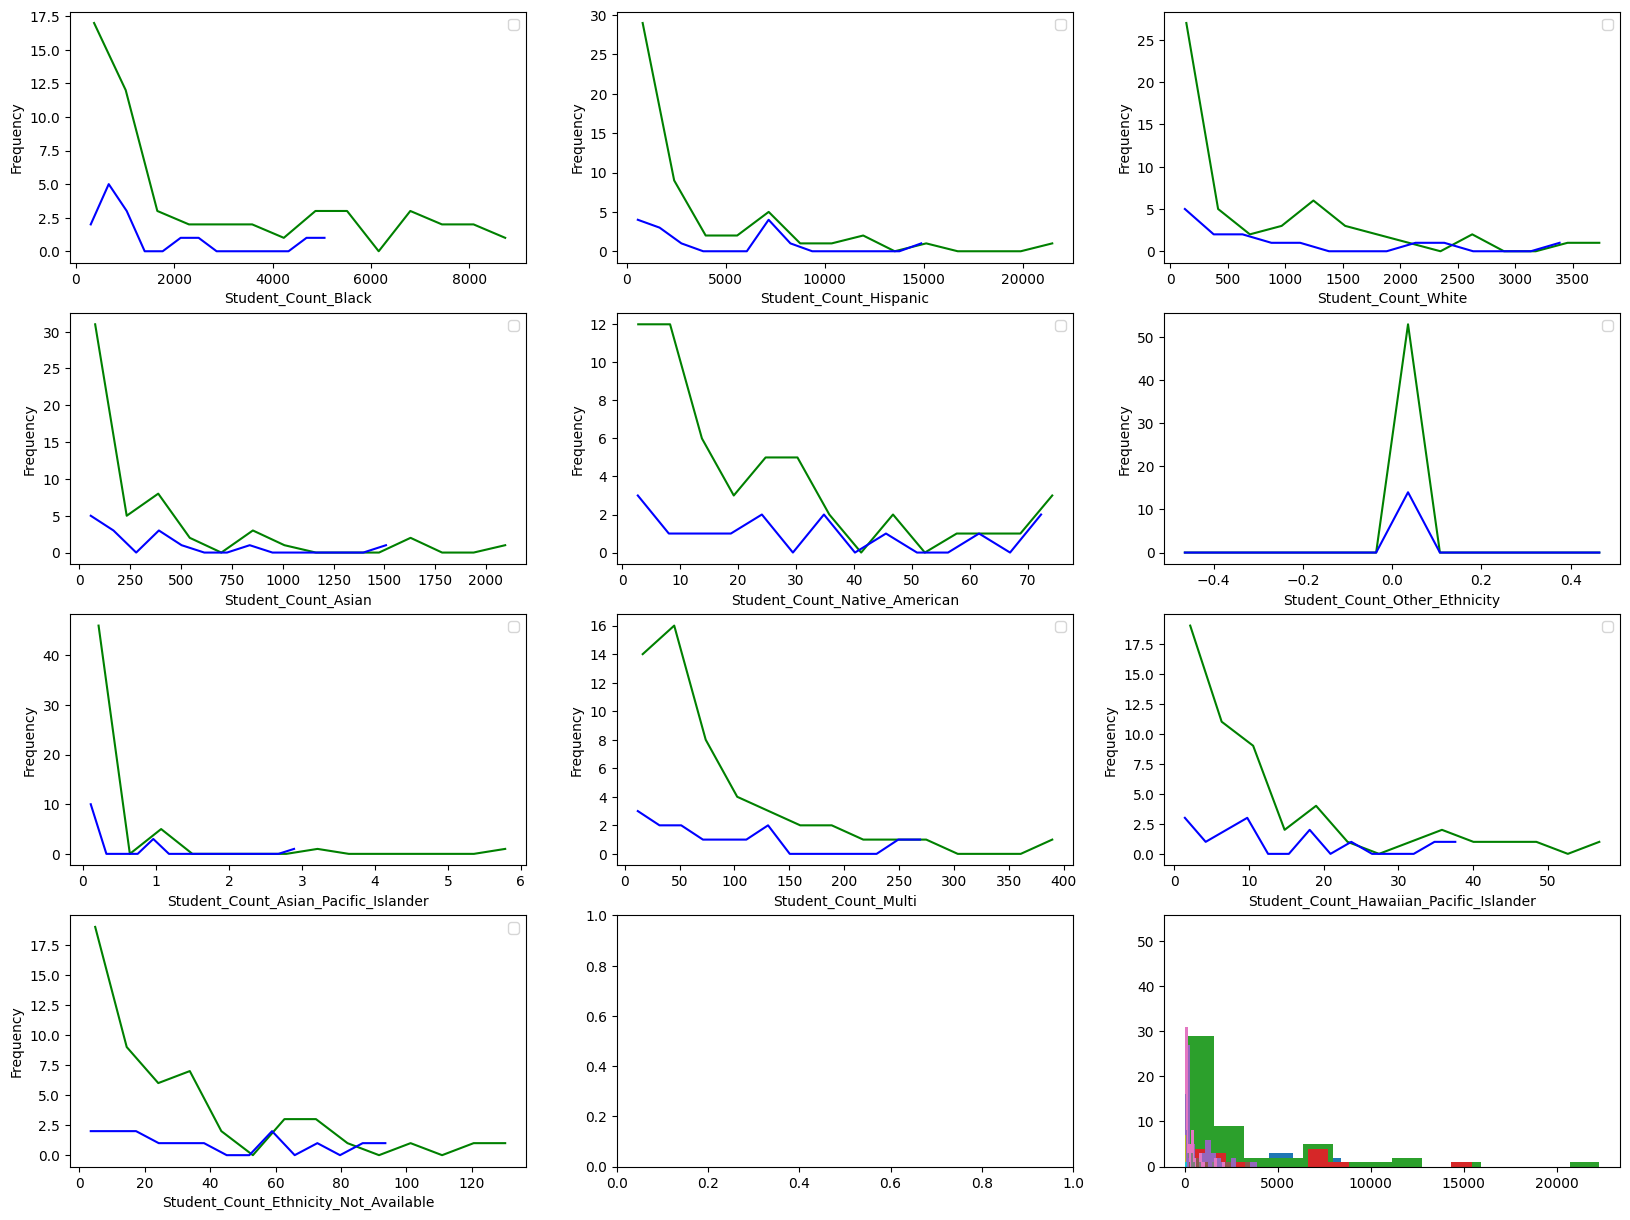

In [311]:
fig, axs = plt.subplots(ncols=3, nrows=4, figsize=(20,15))
axe = axs.ravel()
for idx, attr in enumerate(sensitive_attrs):
    
    # # of bins
    bins_size=len(df_join)//4

    # distribution of sensitive attributes in actual join
    #df_join[attr].plot.hist(xlabel='zip', ylabel=attr, ax=axe[idx], bins=10)
    freq1, bins1, _ = plt.hist(df_join[attr], bins=bins_size)
    axe[idx].plot((bins1[:-1] + bins1[1:]) / 2, freq1, '-', color='green')
    
    # distribution of sesitive attributes in the samples join
    random.seed(123)
    freq2, bins2, _ = plt.hist(sampled_df_join[attr], bins=bins_size)
    axe[idx].plot((bins2[:-1] + bins2[1:]) / 2, freq2, '-', color='blue')
    
    axe[idx].set_xlabel(attr)
    axe[idx].set_ylabel('Frequency')
    axe[idx].legend()
